<a href="https://colab.research.google.com/github/SAMashiyane/ANN_Salary/blob/main/Bruise_Test_MnasNet_with_barlow_twins_v1_samev4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Barlow Twins for Contrastive SSL
**Author**: Seyed ali Mohtarami

**Date created**: 2021

**Last modified**: 2022

**Description**: A pytorch implementation of Barlow Twins (constrastive SSL with redundancy reduction).

## **Introduction**

Self-supervised learning (SSL) is a relatively novel technique in which a model learns from unlabeled data, and is often used when the data is corrupted or if there is very little of it. A practical use for SSL is to create intermediate embeddings that are learned from the data. These embeddings are based on the dataset itself, with similar images having similar embeddings, and vice versa. They are then attached to the rest of the model, which uses those embeddings as information and effectively learns and makes predictions properly. These embeddings, ideally, should contain as much information and insight about the data as possible, so that the model can make better predictions. However, a common problem that arises is that the model creates embeddings that are redundant. For example, if two images are similar, the model will create embeddings that are just a string of 1's, or some other value that contains repeating bits of information. This is no better than a one-hot encoding or just having one bit as the model’s representations; it defeats the purpose of the embeddings, as they do not learn as much about the dataset as possible. For other approaches, the solution to the problem was to carefully configure the model such that it tries not to be redundant.

Barlow Twins is a new approach to this problem; while other solutions mainly tackle the first goal of invariance (similar images have similar embeddings), the Barlow Twins method also prioritizes the goal of reducing redundancy.

It also has the advantage of being much simpler than other methods, and its model architecture is symmetric, meaning that both twins in the model do the same thing. It is also near state-of-the-art on imagenet, even exceeding methods like SimCLR.

One disadvantage of Barlow Twins is that it is heavily dependent on augmentation, suffering major performance decreases in accuracy without them.

TL, DR: Barlow twins creates representations that are:

Invariant.
Not redundant, and carry as much info about the dataset.
Also, it is simpler than other methods.

This notebook can train a Barlow Twins model for bruises customer 

## High-Level Theory

The model takes two versions of the same image(with different augmentations) as
input. Then it takes a prediction of each of them, creating representations.
They are then used to make a cross-correlation matrix.

Cross-correlation matrix:
```
(pred_1.T @ pred_2) / batch_size
```

The cross-correlation matrix measures the correlation between the output
neurons in the two representations made by the model predictions of the two
augmented versions of data. Ideally, a cross-correlation matrix should look
like an identity matrix if the two images are the same.

When this happens, it means that the representations:

1.   Are invariant. The diagonal shows the correlation between each
representation's neurons and its corresponding augmented one. Because the two
versions come from the same image, the diagonal of the matrix should show that
there is a strong correlation between them. If the images are different, there
shouldn't be a diagonal.
2.   Do not show signs of redundancy. If the neurons show correlation with a
non-diagonal neuron, it means that it is not correctly identifying similarities
between the two augmented images. This means that it is redundant.

Here is a good way of understanding in pseudocode(information from the original
paper):

```
c[i][i] = 1
c[i][j] = 0

where:
  c is the cross-correlation matrix
  i is the index of one representation's neuron
  j is the index of the second representation's neuron
```

Taken from the original paper: [Barlow Twins: Self-Supervised Learning via Redundancy
Reduction](https://arxiv.org/abs/2103.03230)

https://user-images.githubusercontent.com/14848164/120419539-b0fab900-c330-11eb-8536-126ce6ce7b85.png

### References

Paper:
[Barlow Twins: Self-Supervised Learning via Redundancy
Reduction](https://arxiv.org/abs/2103.03230)

Original Implementation:
 [facebookresearch/barlowtwins](https://github.com/facebookresearch/barlowtwins)


[link text](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-20_at_7.43.43_PM.png)

In [1]:
!nvidia-smi

Tue Aug  9 05:07:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 20.4 MB/s 


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import glob
import cv2
import shutil
import gc
import os
import time
import datetime
import warnings
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader,Dataset, Subset
import torchvision.models as models
from torchvision.models import resnet18, resnet34 ,resnet50

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
use_gpu = torch.cuda.is_available()

In [5]:
use_gpu

True

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
DATA_DIR = "/content/gdrive/MyDrive/Bruise_datasets"


In [8]:
trn_dir = "/content/gdrive/MyDrive/Bruise_datasets/train"
val_dir = "/content/gdrive/MyDrive/Bruise_datasets/validation"

In [9]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
# import torchtoolbox.transform as transforms
# from cv2.cv2 import CV_32F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt

In [10]:
dataset_directory = '/content/gdrive/MyDrive/Bruise_datasets'
root_directory_train = os.path.join(dataset_directory, "train")
# print(root_directory)
#------------------------------------------------------------------------------------------------------------------------------------------
MoreThanSeventeenDays_directory_train = os.path.join(root_directory_train, "MoreThanSeventeenDays")
NoBruise_directory_train = os.path.join(root_directory_train, "NoBruise")
SeventeenDays_directory_train = os.path.join(root_directory_train, "SeventeenDays")
SixDays_directory_train = os.path.join(root_directory_train, "SixDays")
ThreeDays_directory_train = os.path.join(root_directory_train, "ThreeDays")
TwelveDays_directory_train = os.path.join(root_directory_train, "TwelveDays")
TwoDays_directory_train = os.path.join(root_directory_train, "TwoDays")
#--------------------------------------------------------------------------------------------------------------------------------------------
MoreThanSeventeen_images_filepaths_train = sorted([os.path.join(MoreThanSeventeenDays_directory_train, f) for f in os.listdir(MoreThanSeventeenDays_directory_train)])
NoBruise_directory_images_filepaths_train = sorted([os.path.join(NoBruise_directory_train, f) for f in os.listdir(NoBruise_directory_train)])
SeventeenDays_directory_images_filepaths_train = sorted([os.path.join(SeventeenDays_directory_train, f) for f in os.listdir(SeventeenDays_directory_train)])
SixDays_directory_images_filepaths_train = sorted([os.path.join(SixDays_directory_train, f) for f in os.listdir(SixDays_directory_train)])
ThreeDays_directory_images_filepaths_train = sorted([os.path.join(ThreeDays_directory_train, f) for f in os.listdir(ThreeDays_directory_train)])
TwelveDays_directory_images_filepaths_train = sorted([os.path.join(TwelveDays_directory_train, f) for f in os.listdir(TwelveDays_directory_train)])
TwoDays_directory_images_filepaths_train = sorted([os.path.join(TwoDays_directory_train, f) for f in os.listdir(TwoDays_directory_train)])
#-------------------------------------------------------------------------------------------------------------------------------------------
images_filepaths_train = [*MoreThanSeventeen_images_filepaths_train, *NoBruise_directory_images_filepaths_train,*SeventeenDays_directory_images_filepaths_train,
              *SixDays_directory_images_filepaths_train, *ThreeDays_directory_images_filepaths_train, *TwelveDays_directory_images_filepaths_train,
              *TwoDays_directory_images_filepaths_train]
correct_images_filepaths_train = [i for i in images_filepaths_train if cv2.imread(i) is not None]
# correct_images_filepaths
random.seed(42)
random.shuffle(correct_images_filepaths_train)
#.  ------ >>>>>>>>>>.        correct_images_filepaths_train
print(len(correct_images_filepaths_train))

1712


In [11]:
#                                                   define Imgae filepath validation                            #
dataset_directory = '/content/gdrive/MyDrive/Bruise_datasets'
root_directory_validation = os.path.join(dataset_directory, "validation")
# print(root_directory_validation)
#------------------------------------------------------------------------------------------------------------------------------------------
MoreThanSeventeenDays_directory_validation = os.path.join(root_directory_validation, "MoreThanSeventeenDays")
NoBruise_directory_validation = os.path.join(root_directory_validation, "NoBruise")
SeventeenDays_directory_validation = os.path.join(root_directory_validation, "SeventeenDays")
SixDays_directory_validation = os.path.join(root_directory_validation, "SixDays")
ThreeDays_directory_validation = os.path.join(root_directory_validation, "ThreeDays")
TwelveDays_directory_validation = os.path.join(root_directory_validation, "TwelveDays")
TwoDays_directory_validation = os.path.join(root_directory_validation, "TwoDays")
#--------------------------------------------------------------------------------------------------------------------------------------------
MoreThanSeventeen_images_filepaths_validation = sorted([os.path.join(MoreThanSeventeenDays_directory_validation, f) for f in os.listdir(MoreThanSeventeenDays_directory_validation)])
NoBruise_directory_images_filepaths_validation = sorted([os.path.join(NoBruise_directory_validation, f) for f in os.listdir(NoBruise_directory_validation)])
SeventeenDays_directory_images_filepaths_validation = sorted([os.path.join(SeventeenDays_directory_validation, f) for f in os.listdir(SeventeenDays_directory_validation)])
SixDays_directory_images_filepaths_validation = sorted([os.path.join(SixDays_directory_validation, f) for f in os.listdir(SixDays_directory_validation)])
ThreeDays_directory_images_filepaths_validation = sorted([os.path.join(ThreeDays_directory_validation, f) for f in os.listdir(ThreeDays_directory_validation)])
TwelveDays_directory_images_filepaths_validation = sorted([os.path.join(TwelveDays_directory_validation, f) for f in os.listdir(TwelveDays_directory_validation)])
TwoDays_directory_images_filepaths_validation = sorted([os.path.join(TwoDays_directory_validation, f) for f in os.listdir(TwoDays_directory_validation)])
#-------------------------------------------------------------------------------------------------------------------------------------------
images_filepaths_validation = [*MoreThanSeventeen_images_filepaths_validation, *NoBruise_directory_images_filepaths_validation,*SeventeenDays_directory_images_filepaths_validation,
              *SixDays_directory_images_filepaths_validation, *ThreeDays_directory_images_filepaths_validation, *TwelveDays_directory_images_filepaths_validation,
              *TwoDays_directory_images_filepaths_validation]
correct_images_filepaths_validation = [i for i in images_filepaths_validation if cv2.imread(i) is not None]
# correct_images_filepaths
random.seed(42)
random.shuffle(correct_images_filepaths_validation)
#.  ------ >>>>>>>>>>.        correct_images_filepaths_validation <<<<<<<------------------
print(len(correct_images_filepaths_validation))

215


##Define a PyTorch dataset class

In [12]:
class BruiseDataset(Dataset):
    def __init__(self, images_filepaths, transform=None,transform_prime=None):
        self.images_filepaths = images_filepaths
        self.transform = transform
        self.transform_prime = transform_prime 
        
    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "NoBruise":
            label = 0.0
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "TwoDays":
            label = 1.0  
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "ThreeDays":
            label = 2.0  
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "SixDays":
            label = 3.0  
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "SeventeenDays":
            label = 4.0  
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "TwelveDays":
            label = 5.0                         
        else:     #          ----- >.   MoreThanSeventeenDays
            label = 6.0
        if self.transform is not None:
            image1 = self.transform(image=image)["image"]    
        
        if self.transform_prime is not None:
          image2 = self.transform_prime(image=image)["image"]
            # x = self.transform(image=image)["image"]              
        return (image1,image2),label

## **Model define**

In [13]:
import timm # PyTorch Image Models
# from pprint import pprint
# model_names = timm.list_models(pretrained=True)
# pprint(model_names)

In [14]:
net = timm.create_model('mnasnet_small',pretrained=True) 

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mnasnet_small_lamb-aff75073.pth" to /root/.cache/torch/hub/checkpoints/mnasnet_small_lamb-aff75073.pth


In [ ]:
net

EfficientNet(
  (conv_stem): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (bn1): BatchNormAct2d(
          8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
  

In [15]:
net.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=625), #1536 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=7), 
)

net = net.to(device)

In [ ]:
net

EfficientNet(
  (conv_stem): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (bn1): BatchNormAct2d(
          8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
  

# **Barlow-Twins**

In [16]:
import torch
import torch.nn as nn
'''
Implementation of Barlow Twins (https://arxiv.org/abs/2103.03230), adapted for ease of use for experiments from
https://github.com/facebookresearch/barlowtwins, with some modifications using code from 
https://github.com/lucidrains/byol-pytorch
'''

def flatten(t):
    return t.reshape(t.shape[0], -1)

class NetWrapper(nn.Module):
    # from https://github.com/lucidrains/byol-pytorch
    def __init__(self, net, layer = -2):
        super().__init__()
        self.net = net
        self.layer = layer

        self.hidden = None
        self.hook_registered = False

    def _find_layer(self):
        if type(self.layer) == str:
            modules = dict([*self.net.named_modules()])
            return modules.get(self.layer, None)
        elif type(self.layer) == int:
            children = [*self.net.children()]
            return children[self.layer]
        return None

    def _hook(self, _, __, output):
        self.hidden = flatten(output)

    def _register_hook(self):
        layer = self._find_layer()
        assert layer is not None, f'hidden layer ({self.layer}) not found'
        handle = layer.register_forward_hook(self._hook)
        self.hook_registered = True

    def get_representation(self, x):
        if self.layer == -1:
            return self.net(x)

        if not self.hook_registered:
            self._register_hook()

        _ = self.net(x)
        hidden = self.hidden
        self.hidden = None
        assert hidden is not None, f'hidden layer {self.layer} never emitted an output'
        return hidden

    def forward(self, x):
        representation = self.get_representation(x)

        return representation



def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


class BarlowTwins(nn.Module):
    '''
    Adapted from https://github.com/facebookresearch/barlowtwins for arbitrary backbones, and arbitrary choice of which
    latent representation to use. Designed for models which can fit on a single GPU (though training can be parallelized
    across multiple as with any other model). Support for larger models can be done easily for individual use cases by
    by following PyTorch's model parallelism best practices.
    '''
    def __init__(self, backbone, latent_id, projection_sizes, lambd, scale_factor=1):
        '''
        :param backbone: Model backbone
        :param latent_id: name (or index) of the layer to be fed to the projection MLP
        :param projection_sizes: size of the hidden layers in the projection MLP
        :param lambd: tradeoff function
        :param scale_factor: Factor to scale loss by, default is 1
        '''
        super().__init__()
        self.backbone = backbone
        self.backbone = NetWrapper(self.backbone, latent_id)
        self.lambd = lambd
        self.scale_factor = scale_factor
        # projector
        sizes = projection_sizes
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector = nn.Sequential(*layers)

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)

    def forward(self, y1, y2):
        z1 = self.backbone(y1)
        z2 = self.backbone(y2)
        z1 = self.projector(z1)
        z2 = self.projector(z2)

        # empirical cross-correlation matrix
        c = torch.mm(self.bn(z1).T, self.bn(z2))
        c.div_(z1.shape[0])


        # use --scale-loss to multiply the loss by a constant factor
        # see the Issues section of the readme
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()
        loss = self.scale_factor*(on_diag + self.lambd * off_diag)
        return loss


if __name__=='__main__':
    import torchvision


In [17]:
!pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 26.9 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=f7ecdcd8bef9235893c03934d5d4643233c5a907d032a85a6cad781e6351d754
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [18]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## **AdvancedHairAugmentation**

In [19]:
from albumentations.core.transforms_interface import ImageOnlyTransform
class AdvancedHairAugmentation(ImageOnlyTransform):
  def __init__(self, hairs: int = 4, hairs_folder: str = "", always_apply=False, p=0.5):
      super(AdvancedHairAugmentation, self).__init__(always_apply=always_apply, p=p)
      self.hairs = hairs
      self.hairs_folder = hairs_folder

  def apply(self, image, **params):
      n_hairs = random.randint(0, self.hairs)

      if not n_hairs:
          return image

      height, width, _ = image.shape  # target image width and height
      hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]

      for _ in range(n_hairs):
          hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
          hair = cv2.cvtColor(hair, cv2.COLOR_BGR2RGB)
          hair = cv2.flip(hair, random.choice([-1, 0, 1]))
          hair = cv2.rotate(hair, random.choice([0, 1, 2]))

          h_height, h_width, _ = hair.shape  # hair image width and height
          roi_ho = random.randint(0, abs(image.shape[0] - hair.shape[0]))
          roi_wo = random.randint(0, abs(image.shape[1] - hair.shape[1]))
          if image.shape[0] < hair.shape[0] or image.shape[1] < hair.shape[1]:
             return image
          roi = image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]
          roi = roi.astype(np.uint8) 
          img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
          ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
          mask_inv = cv2.bitwise_not(mask)
          mask_inv = mask_inv.astype(np.uint8)
          img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
          hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

          dst = cv2.add(img_bg, hair_fg)
          image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
      return image

  def get_params_dependent_on_targets(self, params):
      return {}

  @property
  def targets_as_params(self):
      return ["image"]

  def get_transform_init_args_names(self):
      return ()

## **DrawHair_sample**

In [20]:
# class DrawHair_sample:
class DrawHair(ImageOnlyTransform):  

    """
    Draw a random number of pseudo hairs

    Args:
        hairs (int): maximum number of hairs to draw
        width (tuple): possible width of the hair in pixels
    """

    def __init__(self, hairs:int = 4, width:tuple = (1, 2),always_apply=False, p=0.5):
        super(DrawHair, self).__init__(always_apply=always_apply, p=p)
        self.hairs = hairs
        self.width = width

    def apply(self, image,**params):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        if not self.hairs:
            return image
        
        width, height, _ = image.shape
        
        for _ in range(random.randint(0, self.hairs)):
            # The origin point of the line will always be at the top half of the image
            origin = (random.randint(0, width), random.randint(0, height // 2))
            # The end of the line 
            end = (random.randint(0, width), random.randint(0, height))
            color = (0, 0, 0)  # color of the hair. Black.
            cv2.line(image, origin, end, color, random.randint(self.width[0], self.width[1]))
        
        return image
    def get_params_dependent_on_targets(self, params):
      return {}
    @property
    def targets_as_params(self):
      return ["image"]

    def get_transform_init_args_names(self):
       return ()

# Transforms

In [21]:
from albumentations.augmentations.transforms import VerticalFlip
# from torchvision.models.alexnet import alexnet
# image size =  1000 * 1000
# image_size = 256
import albumentations as A
from albumentations.pytorch import ToTensorV2  

transform_first = A.Compose([
                                
              A.Resize(256, 256), 
              # A.RandomCrop(224, 224),
              # A.HorizontalFlip(),
              # A.VerticalFlip(p =0.5),
              # A.RandomContrast(limit=0.2, p=0.75),
              A.Normalize(
                  mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225],
              ),
              ToTensorV2()
])

transform_train = A.Compose([
                             
         AdvancedHairAugmentation(hairs_folder='/content/gdrive/MyDrive/Bruise_datasets/hairs_folder'),
              DrawHair(),                   
              A.Resize(260, 260), 
              A.RandomCrop(256, 256),
              A.Transpose(p=0.5),
              A.VerticalFlip(p =0.5),
              A.HorizontalFlip(p=0.5),
              A.RandomBrightness(limit=0.2, p=0.75),
              A.HorizontalFlip(p=0.5),
              A.RandomContrast(limit=0.2, p=0.75),
              A.OneOf([
                      A.MotionBlur(blur_limit=5),
                      A.MedianBlur(blur_limit=5),
                      # A.GaussianBlur(blur_limit=5),
                      A.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        A.OneOf([
                      A.OpticalDistortion(distort_limit=1.0),
                      A.GridDistortion(num_steps=5, distort_limit=1.),
                      A.ElasticTransform(alpha=3.0),
        ], p=0.7),

        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        
        # A.Cutout(max_h_size=int(256 * 0.375), max_w_size=int(256 * 0.375), num_holes=1, p=0.7),

              A.Normalize(
                  mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225],
              ),
              ToTensorV2() 

                                ])

      # ToTensorV2(),  
      # A.Resize(256, 256),
                                          
      # AdvancedHairAugmentation(hairs_folder='/content/gdrive/MyDrive/Bruise_datasets/hairs_folder'),
      # DrawHair(),
        # albumentations.Transpose(p=0.5),
        # albumentations.VerticalFlip(),
        # albumentations.HorizontalFlip(),
        # albumentations.RandomBrightness(limit=0.2, p=0.75),
        # albumentations.RandomContrast(limit=0.2, p=0.75),
        # albumentations.OneOf([
        #     albumentations.MotionBlur(blur_limit=5),
        #     albumentations.MedianBlur(blur_limit=5),
        #     # albumentations.GaussianBlur(blur_limit=5),
        #     albumentations.GaussNoise(var_limit=(5.0, 30.0)),
        # ], p=0.7),

        # albumentations.OneOf([
        #     albumentations.OpticalDistortion(distort_limit=1.0),
        #     albumentations.GridDistortion(num_steps=5, distort_limit=1.),
        #     albumentations.ElasticTransform(alpha=3.0),
        # ], p=0.7),

        # albumentations.CLAHE(clip_limit=4.0, p=0.7),
        # albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        # albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        
        # albumentations.Cutout(max_h_size=int(image_size * 0.375), max_w_size=int(image_size * 0.375), num_holes=1, p=0.7),
        # A.Normalize(
        #           mean=[0.485, 0.456, 0.406],
        #           std=[0.229, 0.224, 0.225],
        #       ),
        # albumentations.Resize(224, 224)
        
    # transforms.RandomCrop(32, padding=4),  # PIL Image
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=45),
    # transforms.Resize((224,224)),
    #  transforms.RandomHorizontalFlip() ,   # PIL Image
    # transforms.ToTensor(), #  # Tensor
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #  ])
     

transform_valid = A.Compose([
        
        A.Resize(256, 256),
        A.Normalize(
                  mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225],
              ) ,
        ToTensorV2() #     important :::: ToTensor should be the last op.                            
        
    # transforms.Resize((224,224)),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

## ***For example for see*** 

In [ ]:
train_transform_Test = A.Compose([
                                
              A.Resize(256, 256), 
              # A.RandomCrop(224, 224),
              A.HorizontalFlip(),
              A.VerticalFlip(p =0.5),
              A.RandomContrast(limit=0.2, p=0.75),
              A.Normalize(
                  mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225],
              ),
              ToTensorV2()
])
train_transform_test1 = A.Compose([
                                
              A.Resize(256, 256), 
              # A.RandomCrop(224, 224),
              # A.HorizontalFlip(),
              A.Normalize(
                  mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225],
              ),
              ToTensorV2()
])

train_transform_test2 = A.Compose([
                             
        #  AdvancedHairAugmentation(hairs_folder='/content/gdrive/MyDrive/Bruise_datasets/hairs_folder'),
        #       DrawHair(),                   
              A.Resize(260, 260), 
              A.RandomCrop(256, 256),
              A.Transpose(p=0.5),
              A.VerticalFlip(p =0.5),
              A.HorizontalFlip(p=0.5),
              A.RandomBrightness(limit=0.2, p=0.75),
              A.HorizontalFlip(p=0.5),
              A.RandomContrast(limit=0.2, p=0.75),
              A.OneOf([
                      A.MotionBlur(blur_limit=5),
                      A.MedianBlur(blur_limit=5),
                      # A.GaussianBlur(blur_limit=5),
                      A.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        A.OneOf([
                      A.OpticalDistortion(distort_limit=1.0),
                      A.GridDistortion(num_steps=5, distort_limit=1.),
                      A.ElasticTransform(alpha=3.0),
        ], p=0.7),

        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        
        # A.Cutout(max_h_size=int(256 * 0.375), max_w_size=int(256 * 0.375), num_holes=1, p=0.7),

              A.Normalize(
                  mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225],
              ),
              ToTensorV2() 

                                ])


train_dataset = BruiseDataset(images_filepaths=correct_images_filepaths_validation, transform=train_transform_Test,transform_prime=train_transform_test2)

In [ ]:
sample_augment_versions = iter(train_dataset)

In [ ]:
tensor_image = next(sample_augment_versions)

In [ ]:
print((tensor_image[0][1]).shape)

torch.Size([3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


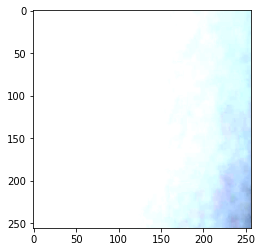

In [ ]:

plt.imshow((tensor_image[0][0].permute(1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


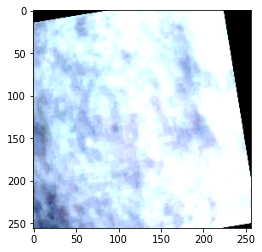

In [ ]:

plt.imshow(tensor_image[0][1].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


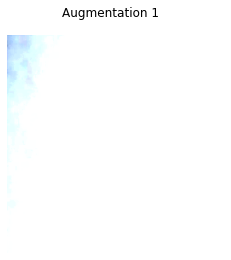

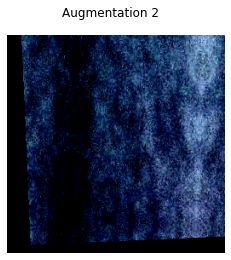

In [ ]:
sample_augment_versions = iter(train_dataset)
# tensor_image = next(iter(train_dataset))

def plot_values(batch: tuple):
    fig, axs = plt.subplots(1, 1)
    fig1, axs1 = plt.subplots(1, 1)

    fig.suptitle("Augmentation 1")
    fig1.suptitle("Augmentation 2")
     
    a1, a2 = batch         
    axs.imshow(a1.permute(1, 2, 0))
    axs.axis("off")
    # axs1[i][j].imshow(a2[3 * i + j])
    axs1.imshow(a2.permute(1, 2, 0))
    axs1.axis("off")

    plt.show()


plot_values(next(sample_augment_versions)[0])

#   Make customer dataset

In [22]:
train_ds = BruiseDataset(images_filepaths=correct_images_filepaths_train, transform=transform_first,transform_prime=transform_train)
valid_ds = BruiseDataset(images_filepaths=correct_images_filepaths_validation, transform=transform_valid,transform_prime=transform_valid)

In [ ]:
# train_dl_test = DataLoader(train_dataset, batch_size,shuffle=True)

In [ ]:
# model = torchvision.models.resnet18()
# # model = net
# proj = [512, 512, 512, 512]
# twins = BarlowTwins(model, 'avgpool', proj, 0.5)
# twins = twins.cuda()
# inp1 = torch.rand(2,3,224,224)
# inp2 = torch.rand(2,3,224,224)
# inp1,inp2 = inp1.cuda(),inp2.cuda()
# loss1 = twins(inp1,inp2)
# print(loss1)

In [ ]:
# for batch_idx, ((x1,x2), _) in enumerate(train_dl_test):
#   print(x1.shape)
#   print(x2.shape)
#   x1, x2 = x1.cuda(), x2.cuda()
#   loss = learner(x1, x2)
#   print(loss)
#   print("###############")
  
  

In [ ]:
# learner = BarlowTwins(net, 'global_pool', [1536,1536, 512, 512],  3.9e-3, 1)
                  
# # learner = BarlowTwins(model, 'avgpool', [512,512, 512, 512],3.9e-3, 1)
                    
# # Note add two 
# learner.cuda()
# optimizer = torch.optim.Adam(learner.parameters(), lr=0.001)
# use_cuda = torch.cuda.is_available()

# #Single training epoch
# for batch_idx, ((x1,x2), _) in enumerate(train_dl_test):
#     if use_cuda:  
#               x1 = x1.type(torch.FloatTensor) 
#               x2 = x2.type(torch.FloatTensor)
#               x1, x2 = x1.cuda(), x2.cuda()
#     # x1, x2 = x1.to(device), x2.to(device)
    
#     loss = learner(x1, x2)
#     optimizer.zero_grad()
#     loss.backward()
    
#     optimizer.step()
#     print(loss)
    
    

In [25]:
len(train_ds), len(valid_ds)

(1712, 215)

In [24]:
from matplotlib import image
batch_size =32


train_dl = DataLoader(train_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=2)
print(len(train_dl))
print(len(train_ds)//batch_size)
print(len(valid_dl))

54
53
7


In [ ]:
train_augment_versions = iter(train_ds)

In [ ]:
train_sample = next(train_augment_versions)

In [ ]:
batch = next(iter(train_dl))
train_data = batch[0][0]
print(train_data.shape)

torch.Size([32, 3, 256, 256])


In [ ]:
y = net(batch[0][0].to(device))

y.shape

torch.Size([32, 7])

In [26]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 25.2 MB/s 


In [ ]:
# net.state_dict()

In [ ]:
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

conv_stem.weight 	 torch.Size([8, 3, 3, 3])
bn1.weight 	 torch.Size([8])
bn1.bias 	 torch.Size([8])
bn1.running_mean 	 torch.Size([8])
bn1.running_var 	 torch.Size([8])
bn1.num_batches_tracked 	 torch.Size([])
blocks.0.0.conv_dw.weight 	 torch.Size([8, 1, 3, 3])
blocks.0.0.bn1.weight 	 torch.Size([8])
blocks.0.0.bn1.bias 	 torch.Size([8])
blocks.0.0.bn1.running_mean 	 torch.Size([8])
blocks.0.0.bn1.running_var 	 torch.Size([8])
blocks.0.0.bn1.num_batches_tracked 	 torch.Size([])
blocks.0.0.conv_pw.weight 	 torch.Size([8, 8, 1, 1])
blocks.0.0.bn2.weight 	 torch.Size([8])
blocks.0.0.bn2.bias 	 torch.Size([8])
blocks.0.0.bn2.running_mean 	 torch.Size([8])
blocks.0.0.bn2.running_var 	 torch.Size([8])
blocks.0.0.bn2.num_batches_tracked 	 torch.Size([])
blocks.1.0.conv_pw.weight 	 torch.Size([24, 8, 1, 1])
blocks.1.0.bn1.weight 	 torch.Size([24])
blocks.1.0.bn1.bias 	 torch.Size([24])
blocks.1.0.bn1.running_mean 	 torch.Size([24])
blocks.1.0.bn1.running_var 	 torch.Size([24])
blocks.1.0.bn1.

In [ ]:
# for param_tensor in net.state_dict():
#     print(param_tensor, "\t", net.state_dict()[param_tensor].size())
net.state_dict()['conv_stem.weight'].size()
    

torch.Size([16, 3, 3, 3])

In [ ]:
# net

In [ ]:
net.state_dict()['conv_stem.weight'][0] # --> First kernel from 16th Kernel (3*3*3)

tensor([[[ 0.4609,  0.7490,  0.2524],
         [-0.4915, -0.6818, -0.3347],
         [-0.0075, -0.0544,  0.1374]],

        [[ 1.0604,  1.6373,  0.4870],
         [-1.0994, -1.4830, -0.6447],
         [-0.0127, -0.1636,  0.1882]],

        [[ 0.2251,  0.3674,  0.1637],
         [-0.1897, -0.2725, -0.1223],
         [-0.1065, -0.0522, -0.0695]]], device='cuda:0')

# Freezing layer in MnasNet

In [ ]:
for name,param in net.named_parameters():
  if "6"  in name or  "5"  in name :
    # param.requires_grad = True
    print(name)

blocks.5.0.conv_pw.weight
blocks.5.0.bn1.weight
blocks.5.0.bn1.bias
blocks.5.0.conv_dw.weight
blocks.5.0.bn2.weight
blocks.5.0.bn2.bias
blocks.5.0.se.conv_reduce.weight
blocks.5.0.se.conv_reduce.bias
blocks.5.0.se.conv_expand.weight
blocks.5.0.se.conv_expand.bias
blocks.5.0.conv_pwl.weight
blocks.5.0.bn3.weight
blocks.5.0.bn3.bias
blocks.5.1.conv_pw.weight
blocks.5.1.bn1.weight
blocks.5.1.bn1.bias
blocks.5.1.conv_dw.weight
blocks.5.1.bn2.weight
blocks.5.1.bn2.bias
blocks.5.1.se.conv_reduce.weight
blocks.5.1.se.conv_reduce.bias
blocks.5.1.se.conv_expand.weight
blocks.5.1.se.conv_expand.bias
blocks.5.1.conv_pwl.weight
blocks.5.1.bn3.weight
blocks.5.1.bn3.bias
blocks.5.2.conv_pw.weight
blocks.5.2.bn1.weight
blocks.5.2.bn1.bias
blocks.5.2.conv_dw.weight
blocks.5.2.bn2.weight
blocks.5.2.bn2.bias
blocks.5.2.se.conv_reduce.weight
blocks.5.2.se.conv_reduce.bias
blocks.5.2.se.conv_expand.weight
blocks.5.2.se.conv_expand.bias
blocks.5.2.conv_pwl.weight
blocks.5.2.bn3.weight
blocks.5.2.bn3.bias
b

In [ ]:
net

EfficientNet(
  (conv_stem): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (bn1): BatchNormAct2d(
          8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
  

In [ ]:
for name,param in net.named_parameters():
  if "5"  in name or "6" in name :
    param.requires_grad = True
    print(name)
  else:
    param.requires_grad = False  
  # print(name)

blocks.5.0.conv_pw.weight
blocks.5.0.bn1.weight
blocks.5.0.bn1.bias
blocks.5.0.conv_dw.weight
blocks.5.0.bn2.weight
blocks.5.0.bn2.bias
blocks.5.0.se.conv_reduce.weight
blocks.5.0.se.conv_reduce.bias
blocks.5.0.se.conv_expand.weight
blocks.5.0.se.conv_expand.bias
blocks.5.0.conv_pwl.weight
blocks.5.0.bn3.weight
blocks.5.0.bn3.bias
blocks.5.1.conv_pw.weight
blocks.5.1.bn1.weight
blocks.5.1.bn1.bias
blocks.5.1.conv_dw.weight
blocks.5.1.bn2.weight
blocks.5.1.bn2.bias
blocks.5.1.se.conv_reduce.weight
blocks.5.1.se.conv_reduce.bias
blocks.5.1.se.conv_expand.weight
blocks.5.1.se.conv_expand.bias
blocks.5.1.conv_pwl.weight
blocks.5.1.bn3.weight
blocks.5.1.bn3.bias
blocks.5.2.conv_pw.weight
blocks.5.2.bn1.weight
blocks.5.2.bn1.bias
blocks.5.2.conv_dw.weight
blocks.5.2.bn2.weight
blocks.5.2.bn2.bias
blocks.5.2.se.conv_reduce.weight
blocks.5.2.se.conv_reduce.bias
blocks.5.2.se.conv_expand.weight
blocks.5.2.se.conv_expand.bias
blocks.5.2.conv_pwl.weight
blocks.5.2.bn3.weight
blocks.5.2.bn3.bias
b

In [27]:
learner = BarlowTwins(net, 'global_pool', [1280,1280, 512, 512],  3.9e-3, 1)
                  
# learner = BarlowTwins(model, 'avgpool', [512,512, 512, 512],3.9e-3, 1)
                    
# Note add two 
learner.cuda()
optimizer_Barlow_Twin = torch.optim.Adam(learner.parameters(), lr=0.001)
use_cuda = torch.cuda.is_available()

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:

learner = BarlowTwins(net, 'global_pool', [1280,1280, 512, 512],  3.9e-3, 1)
                  
# learner = BarlowTwins(model, 'avgpool', [512,512, 512, 512],3.9e-3, 1)
                    
# Note add two 
learner.cuda()
optimizer_Barlow_Twin = torch.optim.Adam(learner.parameters(), lr=0.001)
use_cuda = torch.cuda.is_available()

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
losses = []

for epoch in range(0, 100):
  # initialize variables to monitor training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    
    loss_total_train_Barlow = AverageMeter()
    
    # precision_train = torchmetrics.Precision(average='macro', num_classes=7).cuda()

    for batch_idx, ((x1,x2), _) in enumerate(train_dl):
         if use_cuda:  
              x1 = x1.type(torch.FloatTensor) 
              x2 = x2.type(torch.FloatTensor)
              x1, x2 = x1.cuda(), x2.cuda()
         x1, x2 = x1.to(device), x2.to(device)
         optimizer_Barlow_Twin.zero_grad()
         loss_Barlow = learner(x1, x2)
         loss_Barlow.backward()
         
         optimizer_Barlow_Twin.step()
        #  print(loss)
        
         loss_total_train_Barlow.update(loss_Barlow)
        
        # precision_train(outputs.softmax(dim=-1), targets)
      # print(targets[:10])
        # if batch_idx == 30:
      #    break
        # scheduler.step()
      # Save checkpoint
      
       
    
    # pre_train = precision_train.compute()      
    
    print(f'Train: Epoch:{epoch} Loss_Barlow:{loss_total_train_Barlow.avg:.4} ')
    checkpoint_BL = {
            'epoch': epoch + 1,
              'valid_loss_min': loss_total_train_Barlow.avg,
              'state_dict': net.state_dict(), # --> Model Weights
              'optimizer': optimizer_Barlow_Twin.state_dict(),  
               
            }
    torch.save(checkpoint_BL, "/content/gdrive/MyDrive/Bruise_datasets/Barlow_Twins/BL_checkpoint_MnasNetV1.pt")        


Train: Epoch:0 Loss_Barlow:165.2 
Train: Epoch:1 Loss_Barlow:122.9 
Train: Epoch:2 Loss_Barlow:116.8 
Train: Epoch:3 Loss_Barlow:110.6 
Train: Epoch:4 Loss_Barlow:111.1 
Train: Epoch:5 Loss_Barlow:102.6 
Train: Epoch:6 Loss_Barlow:97.53 
Train: Epoch:7 Loss_Barlow:93.87 
Train: Epoch:8 Loss_Barlow:91.62 
Train: Epoch:9 Loss_Barlow:86.9 
Train: Epoch:10 Loss_Barlow:85.23 
Train: Epoch:11 Loss_Barlow:86.92 
Train: Epoch:12 Loss_Barlow:87.96 
Train: Epoch:13 Loss_Barlow:88.13 
Train: Epoch:14 Loss_Barlow:87.0 
Train: Epoch:15 Loss_Barlow:80.69 
Train: Epoch:16 Loss_Barlow:83.25 
Train: Epoch:17 Loss_Barlow:86.39 
Train: Epoch:18 Loss_Barlow:81.57 
Train: Epoch:19 Loss_Barlow:79.18 
Train: Epoch:20 Loss_Barlow:80.59 
Train: Epoch:21 Loss_Barlow:78.93 
Train: Epoch:22 Loss_Barlow:82.64 
Train: Epoch:23 Loss_Barlow:76.15 
Train: Epoch:24 Loss_Barlow:75.31 
Train: Epoch:25 Loss_Barlow:76.12 
Train: Epoch:26 Loss_Barlow:75.96 
Train: Epoch:27 Loss_Barlow:78.72 
Train: Epoch:28 Loss_Barlow:77.7

In [28]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [29]:
checkpoint_BL = torch.load('/content/gdrive/MyDrive/Bruise_datasets/Barlow_Twins/BL_checkpoint_MnasNetV1.pt')

In [30]:
net.load_state_dict(checkpoint_BL['state_dict'])

<All keys matched successfully>

In [ ]:
# net.state_dict()['conv_stem.weight'][0]

In [ ]:
net

EfficientNet(
  (conv_stem): Conv2dSame(3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
     

In [ ]:
for name,param in net.named_parameters():
  if "5"  in name or 'classifier' in name:
    # param.requires_grad = True
    print(name)

blocks.5.0.conv_pw.weight
blocks.5.0.bn1.weight
blocks.5.0.bn1.bias
blocks.5.0.conv_dw.0.weight
blocks.5.0.conv_dw.1.weight
blocks.5.0.conv_dw.2.weight
blocks.5.0.conv_dw.3.weight
blocks.5.0.conv_dw.4.weight
blocks.5.0.bn2.weight
blocks.5.0.bn2.bias
blocks.5.0.se.conv_reduce.weight
blocks.5.0.se.conv_reduce.bias
blocks.5.0.se.conv_expand.weight
blocks.5.0.se.conv_expand.bias
blocks.5.0.conv_pwl.weight
blocks.5.0.bn3.weight
blocks.5.0.bn3.bias
blocks.5.1.conv_pw.weight
blocks.5.1.bn1.weight
blocks.5.1.bn1.bias
blocks.5.1.conv_dw.0.weight
blocks.5.1.conv_dw.1.weight
blocks.5.1.conv_dw.2.weight
blocks.5.1.conv_dw.3.weight
blocks.5.1.bn2.weight
blocks.5.1.bn2.bias
blocks.5.1.se.conv_reduce.weight
blocks.5.1.se.conv_reduce.bias
blocks.5.1.se.conv_expand.weight
blocks.5.1.se.conv_expand.bias
blocks.5.1.conv_pwl.0.weight
blocks.5.1.conv_pwl.1.weight
blocks.5.1.bn3.weight
blocks.5.1.bn3.bias
blocks.5.2.conv_pw.weight
blocks.5.2.bn1.weight
blocks.5.2.bn1.bias
blocks.5.2.conv_dw.0.weight
blocks.

In [ ]:
for name,param in net.named_parameters():
  if "5"  in name or "6" in name :
    param.requires_grad = False
    print(name)
  else:
    param.requires_grad = True  
  # print(name)

blocks.5.0.conv_pw.weight
blocks.5.0.bn1.weight
blocks.5.0.bn1.bias
blocks.5.0.conv_dw.weight
blocks.5.0.bn2.weight
blocks.5.0.bn2.bias
blocks.5.0.se.conv_reduce.weight
blocks.5.0.se.conv_reduce.bias
blocks.5.0.se.conv_expand.weight
blocks.5.0.se.conv_expand.bias
blocks.5.0.conv_pwl.weight
blocks.5.0.bn3.weight
blocks.5.0.bn3.bias
blocks.5.1.conv_pw.weight
blocks.5.1.bn1.weight
blocks.5.1.bn1.bias
blocks.5.1.conv_dw.weight
blocks.5.1.bn2.weight
blocks.5.1.bn2.bias
blocks.5.1.se.conv_reduce.weight
blocks.5.1.se.conv_reduce.bias
blocks.5.1.se.conv_expand.weight
blocks.5.1.se.conv_expand.bias
blocks.5.1.conv_pwl.weight
blocks.5.1.bn3.weight
blocks.5.1.bn3.bias
blocks.5.2.conv_pw.weight
blocks.5.2.bn1.weight
blocks.5.2.bn1.bias
blocks.5.2.conv_dw.weight
blocks.5.2.bn2.weight
blocks.5.2.bn2.bias
blocks.5.2.se.conv_reduce.weight
blocks.5.2.se.conv_reduce.bias
blocks.5.2.se.conv_expand.weight
blocks.5.2.se.conv_expand.bias
blocks.5.2.conv_pwl.weight
blocks.5.2.bn3.weight
blocks.5.2.bn3.bias
b

In [ ]:
# for name,param in net.named_parameters():
#   if "5"  in name :
#     param.requires_grad = False
#     print(name)
#   else:
#     param.requires_grad = True  
  # print(name)

blocks.5.0.conv_pw.weight
blocks.5.0.bn1.weight
blocks.5.0.bn1.bias
blocks.5.0.conv_dw.0.weight
blocks.5.0.conv_dw.1.weight
blocks.5.0.conv_dw.2.weight
blocks.5.0.conv_dw.3.weight
blocks.5.0.conv_dw.4.weight
blocks.5.0.bn2.weight
blocks.5.0.bn2.bias
blocks.5.0.se.conv_reduce.weight
blocks.5.0.se.conv_reduce.bias
blocks.5.0.se.conv_expand.weight
blocks.5.0.se.conv_expand.bias
blocks.5.0.conv_pwl.weight
blocks.5.0.bn3.weight
blocks.5.0.bn3.bias
blocks.5.1.conv_pw.weight
blocks.5.1.bn1.weight
blocks.5.1.bn1.bias
blocks.5.1.conv_dw.0.weight
blocks.5.1.conv_dw.1.weight
blocks.5.1.conv_dw.2.weight
blocks.5.1.conv_dw.3.weight
blocks.5.1.bn2.weight
blocks.5.1.bn2.bias
blocks.5.1.se.conv_reduce.weight
blocks.5.1.se.conv_reduce.bias
blocks.5.1.se.conv_expand.weight
blocks.5.1.se.conv_expand.bias
blocks.5.1.conv_pwl.0.weight
blocks.5.1.conv_pwl.1.weight
blocks.5.1.bn3.weight
blocks.5.1.bn3.bias
blocks.5.2.conv_pw.weight
blocks.5.2.bn1.weight
blocks.5.2.bn1.bias
blocks.5.2.conv_dw.0.weight
blocks.

In [ ]:
# for name,param in net.named_parameters():
#   if "classifier" in name:
#     param.requires_grad = True
#     print(name)
#   else:
#     param.requires_grad = False  
#   # print(name)

classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.5.weight
classifier.5.bias


In [31]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# batch = next(iter(train_dl_test))
# train_data = batch[0]
# len(batch[0])

In [ ]:
# batch[1]

In [ ]:
# y = net(batch[0][0].to(device))

# y.shape

In [ ]:
# batch[1] =batch[1].type(torch.LongTensor)
# # label = label.type(torch.LongTensor)
# criterion(y, batch[1].to(device))

In [32]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    
    
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [33]:
def load_ckp(checkpoint_fpath, model, optimizer):
    # load check point
    # if torch.cuda.is_available() == False:

    #   checkpoint = torch.load(checkpoint_fpath,map_location ='cpu')
    # else:
    checkpoint = torch.load(checkpoint_fpath)
    
    # initialize state_dict from checkpoint to model--->checkpoint = { 'state_dict': model.state_dict() }  
    # model.load_state_dict(torch.load('model_weights.pth'))      
    model.load_state_dict(checkpoint['state_dict']) # --> model.load_state_dict(model.state_dict())
    # initialize optimizer from checkpoint to optimizer--->checkpoint = { 'optimizer': optimizer.state_dict()}
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    acc = checkpoint['acc_valid_max']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item(),checkpoint['acc_valid_max']

In [34]:
import sys
import torchmetrics

In [ ]:
# net.state_dict()

In [ ]:
# from torchmetrics import Accuracy
# from torchmetrics import Precision
# for epoch in range(0,10):
#       # initialize variables to monitor training and validation loss
#         train_loss = 0.0
#         valid_loss = 0.0
#         ###################
#         # train the model #
#         ###################
#         net1.train()
#         # for name,param in net.named_parameters():
#         #   if "classifier" in name:
#         #     param.requires_grad = True
#         #     print(name)
#         #   else:
#         #     param.requires_grad = False 
            
#         loss_total_train = AverageMeter()
#         accuracy_train = torchmetrics.Accuracy().cuda()
#         # precision_train = torchmetrics.Precision(average='macro', num_classes=7).cuda()
        
#         for batch_idx, (inputs, targets) in enumerate(train_dl):
#           #move to GPU:
#             if use_cuda:  
#                 targets = targets.type(torch.LongTensor)   
#                 inputs, targets = inputs[0].cuda(), targets.cuda()
#             inputs, targets = inputs.to(device), targets.to(device)
#             optimizer.zero_grad()
#             outputs = net1 (inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             loss_total_train.update(loss)
#             accuracy_train(outputs.softmax(dim=-1), targets)
#             # precision_train(outputs.softmax(dim=-1), targets)
#           # print(targets[:10])
#            # if batch_idx == 30:
#           #    break
#             # scheduler.step()
     
#         acc_train = accuracy_train.compute()
#         # # pre_train = precision_train.compute()      
         
#         print(f'Train: Epoch:{epoch} Loss:{loss_total_train.avg:.4} Accuracy:{acc_train:.4} ')
#         # print(net.state_dict())
#         print(net1.state_dict()['conv_stem.weight'][0])
#         print(net1.state_dict()['classifier.5.weight'])
       

In [35]:
dataloaders ={'train':train_dl,'valid':valid_dl}

In [36]:
from torchmetrics import Accuracy
from torchmetrics import Precision
def train(start_epoch,end_epoch,acc_valid_input, loaders, model, optimizer, criterion, use_cuda, checkpoint_path, best_model_path):
    acc_valid_max= acc_valid_input 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    use_cuda = torch.cuda.is_available()
    losses = []

    for epoch in range(start_epoch,end_epoch):
      # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        loss_total_train = AverageMeter()
        accuracy_train = torchmetrics.Accuracy().cuda()
        # precision_train = torchmetrics.Precision(average='macro', num_classes=7).cuda()
         
        for batch_idx, (inputs, targets) in enumerate(train_dl):
          
          #move to GPU:
            if use_cuda:  
                targets = targets.type(torch.LongTensor)   
                inputs, targets = inputs[0].cuda(), targets.cuda()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            for name,param in model.named_parameters():
              if "classifier" in name:
                  param.requires_grad = True
                  # print(name)
              else:
                param.requires_grad = False
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            loss_total_train.update(loss)
            accuracy_train(outputs.softmax(dim=-1), targets)
            # precision_train(outputs.softmax(dim=-1), targets)
          # print(targets[:10])
           # if batch_idx == 30:
          #    break
            # scheduler.step()
     
        acc_train = accuracy_train.compute()
        # pre_train = precision_train.compute()      
        # writer.add_scalar('Loss/train', loss_total_train.avg.item(), epoch)
        # writer.add_scalar('Acc/train', acc_train.item(), epoch)
        print(f'Train: Epoch:{epoch} Loss:{loss_total_train.avg:.4} Accuracy:{acc_train:.4} ')
        ######################    
        # validate the model #
        ######################
        model.eval()
        loss_total_valid = AverageMeter()
        accuracy_valid = torchmetrics.Accuracy().cuda()
        # precision_valid = torchmetrics.Precision(average='macro', num_classes=7).cuda()
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(valid_dl):
                targets = targets.type(torch.LongTensor) 
                inputs, targets = inputs[0].to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss_total_valid.update(loss)
                accuracy_valid(outputs.softmax(dim=-1), targets)
                # precision_valid(outputs.softmax(dim=-1), targets)
            acc_valid = accuracy_valid.compute()
            # pre_valid = precision_valid.compute()
            # writer.add_scalar('Loss/test', loss_total_valid.avg.item(), epoch)
            # writer.add_scalar('Acc/test', acc_valid.item(), epoch)
            print(f'Test:  Epoch:{epoch} Loss:{loss_total_valid.avg:.4} Accuracy:{acc_valid:.4} ')
            print()           
      # Save checkpoint
      
        checkpoint = {
            'epoch': epoch + 1,
              'valid_loss_min': loss_total_valid.avg,
              'state_dict': model.state_dict(), # --> Model Weights
              'optimizer': optimizer.state_dict(),  
              'acc_valid_max':acc_valid , 
            }
          # make   checkpoint_path 
        # checkpoint_path = '/content/challenge/checkpoint/'
        # if not os.path.exists(checkpoint_path):
        #     os.makedirs(checkpoint_path)
        # else:
        #   pass    
        # best_model_path = '/content/challenge/best_model/' 
        # if not os.path.exists(best_model_path):
        #     os.makedirs(best_model_path)   
        # else:
        #   pass 
          # save checkpoint
          
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
        ## TODO: save the model if validation loss has decreased
        if acc_valid > acc_valid_max:
            print('accuracy_valid increased ({:.6f} --> {:.6f}).  Saving model ...'.format(acc_valid_max,acc_valid))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            acc_valid_max = acc_valid
   
    # return trained model
    return model, losses

In [37]:
use_cuda = torch.cuda.is_available()

In [ ]:
trained_model = train(1,300, 0, dataloaders, net, optimizer, criterion, use_cuda, "/content/gdrive/MyDrive/Bruise_datasets/mnasnet_barowtwins_v1v4/current_checkpoint.pt", "/content/gdrive/MyDrive/Bruise_datasets/mnasnet_barowtwins_v1v4/best_model.pt")

Train: Epoch:1 Loss:1.306 Accuracy:0.5041 
Test:  Epoch:1 Loss:1.093 Accuracy:0.5581 

accuracy_valid increased (0.000000 --> 0.558140).  Saving model ...
Train: Epoch:2 Loss:1.023 Accuracy:0.6162 
Test:  Epoch:2 Loss:0.9783 Accuracy:0.6279 

accuracy_valid increased (0.558140 --> 0.627907).  Saving model ...
Train: Epoch:3 Loss:0.9554 Accuracy:0.6507 
Test:  Epoch:3 Loss:0.8938 Accuracy:0.6419 

accuracy_valid increased (0.627907 --> 0.641860).  Saving model ...
Train: Epoch:4 Loss:0.8687 Accuracy:0.6735 
Test:  Epoch:4 Loss:0.8918 Accuracy:0.6651 

accuracy_valid increased (0.641860 --> 0.665116).  Saving model ...
Train: Epoch:5 Loss:0.8199 Accuracy:0.6992 
Test:  Epoch:5 Loss:0.8416 Accuracy:0.6744 

accuracy_valid increased (0.665116 --> 0.674419).  Saving model ...
Train: Epoch:6 Loss:0.7739 Accuracy:0.7114 
Test:  Epoch:6 Loss:0.8504 Accuracy:0.6791 

accuracy_valid increased (0.674419 --> 0.679070).  Saving model ...
Train: Epoch:7 Loss:0.7195 Accuracy:0.7336 
Test:  Epoch:7 Lo

In [38]:
ckp_path = "/content/gdrive/MyDrive/Bruise_datasets/mnasnet_barowtwins_v1v4/current_checkpoint.pt"
# model, optimizer, checkpoint['epoch'], valid_loss_min.item(),checkpoint['acc']
net, optimizer, start_epoch, valid_loss_min,accuracy_valid = load_ckp(ckp_path, net, optimizer)

In [39]:
# print("model = ", net)
print("optimizer = ", optimizer)
print("start_epoch = ", start_epoch)
# print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))
print("accuracy_valid = {:.4f}".format(accuracy_valid))

optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
start_epoch =  300
valid_loss_min = 0.456643
accuracy_valid = 0.8930


## **Step 4. Model evaluation**

In [40]:
import itertools 

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix

In [ ]:
# classes = valid_ds.classes
# print(classes)

In [ ]:
with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(valid_dl):
                targets = targets.type(torch.LongTensor) 
                inputs, targets = inputs[0].to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss_total_valid.update(loss)
                accuracy_valid(outputs.softmax(dim=-1), targets)
                # precision_valid(outputs.softmax(dim=-1), targets)
            acc_valid = accuracy_valid.compute()
            # pre_valid = precision_valid.compute()
            # writer.add_scalar('Loss/test', loss_total_valid.avg.item(), epoch)
            # writer.add_scalar('Acc/test', acc_valid.item(), epoch)
            print(f'Test:  Epoch:{epoch} Loss:{loss_total_valid.avg:.4} Accuracy:{acc_valid:.4} ')
            print()           

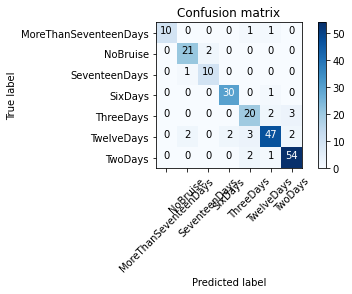

In [43]:
net.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(valid_dl):
        # images, labels = data
        targets = targets.type(torch.LongTensor) 
        inputs, targets = inputs[0].to(device), targets.to(device)
        N = inputs.size(0)
        inputs = Variable(inputs).to(device)
        outputs = net(inputs)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(targets.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['MoreThanSeventeenDays', 'NoBruise', 'SeventeenDays', 'SixDays', 'ThreeDays', 'TwelveDays', 'TwoDays']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [44]:
from sklearn.metrics import classification_report

In [45]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

                       precision    recall  f1-score   support

MoreThanSeventeenDays       1.00      0.83      0.91        12
             NoBruise       0.88      0.91      0.89        23
        SeventeenDays       0.83      0.91      0.87        11
              SixDays       0.94      0.97      0.95        31
            ThreeDays       0.77      0.80      0.78        25
           TwelveDays       0.90      0.84      0.87        56
              TwoDays       0.92      0.95      0.93        57

             accuracy                           0.89       215
            macro avg       0.89      0.89      0.89       215
         weighted avg       0.89      0.89      0.89       215



Text(0, 0.5, 'Fraction classified incorrectly')

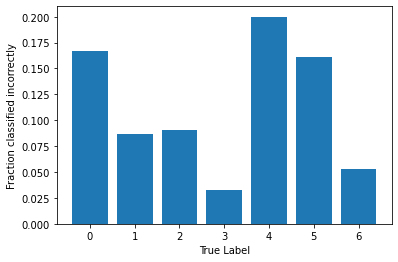

In [46]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [47]:
import itertools
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
classes =['NoBruise', 'TwoDays','ThreeDays','SixDays','SeventeenDays', 'TwelveDays','MoreThanSeventeenDays']
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def imshow(inp, title=None):
    """Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)


def visualize_model(model, dataloader, device, num_images=10):
    """ Visulaize the prediction of the model on a bunch of random data.
    """
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10., 8.))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs[0].to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            print(preds)
            print(labels)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('label: {} predicted: {}'.format(labels[j],preds[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

def plot_errors(model, dataloader, device):
    model.eval()
    plt.figure(figsize=(12, 24))
    count = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs[0].to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            incorrect_idxs = np.flatnonzero(preds.cpu().numpy() != labels.cpu().numpy())

            for idx in incorrect_idxs:
                count += 1
                if count > 30: break
                ax = plt.subplot(10, 3, count)
                ax.axis('off')
                ax.set_title('predicted: {}'.format([preds[idx]]))
                imshow(inputs.cpu().data[idx])
    
    plt.show()

    print("{} images out of {} were misclassified.".format(count, len(dataloader.dataset)))

tensor([1, 5, 4, 0, 1, 6, 1, 3, 5, 4, 5, 4, 0, 2, 6, 3, 5, 5, 5, 6, 5, 6, 4, 3,
        4, 6, 1, 3, 3, 3, 6, 5], device='cuda:0')
tensor([1., 5., 5., 0., 1., 6., 1., 3., 5., 4., 5., 4., 0., 2., 6., 3., 5., 4.,
        5., 6., 5., 6., 4., 3., 4., 6., 1., 3., 3., 3., 6., 5.],
       device='cuda:0', dtype=torch.float64)


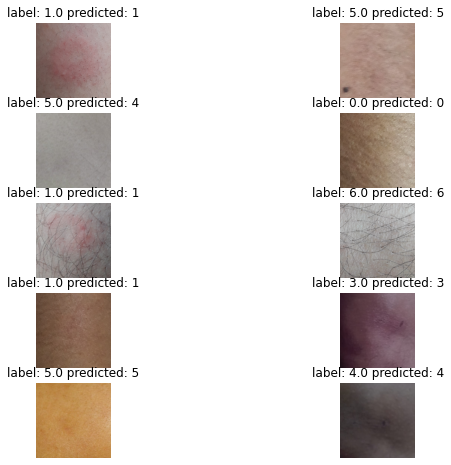

In [48]:
visualize_model(net, valid_dl,device)

100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


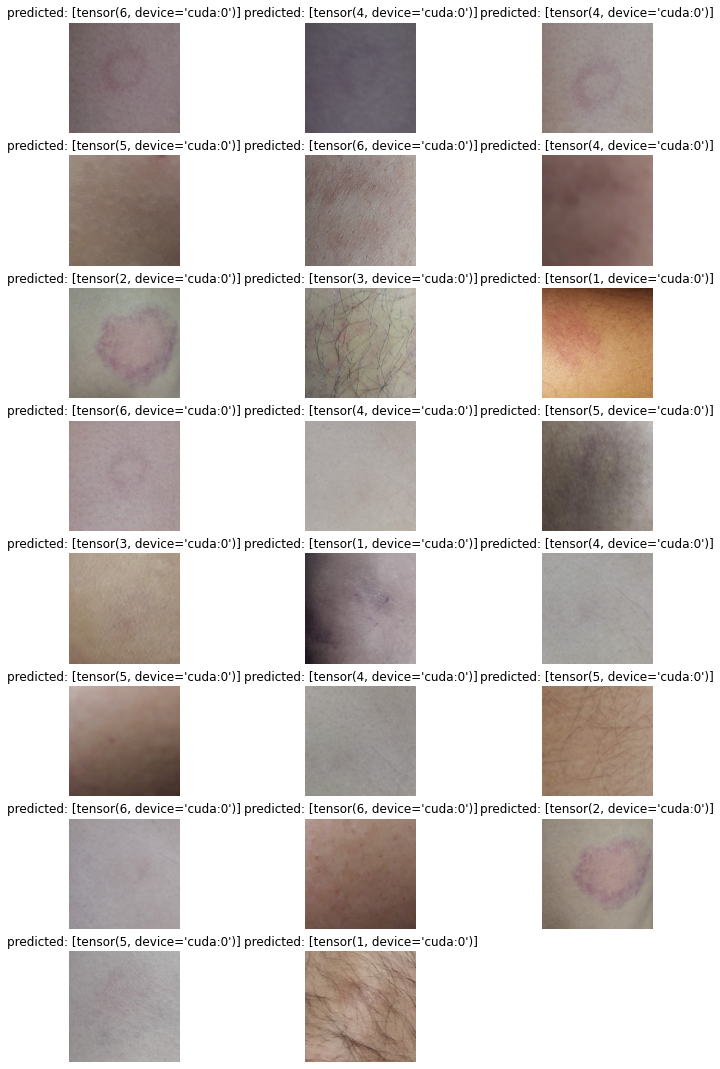

23 images out of 215 were misclassified.


In [49]:
plot_errors(net, valid_dl,device)